In [1]:
#加载使用的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### ●问题描述
<p> 1912年4月15日，泰坦尼克号在她的处女航中撞上冰山后沉没，结束了她光辉而短暂的旅途。2224名乘客以及船员中有1502人丧生，存活率仅32%。
<p> 现在我们得到了一份记录了乘客的各种信息以及该乘客是否生还的训练数据和一份含有乘客信息但生还未知的测试数据，我们要根据训练数据建立一个模型来预测测试数据中乘客的生还情况。

### ●获取数据并初步观察

In [2]:
#提取数据
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
total_data = [train_df, test_df]

In [3]:
#简单观察几行数据
print(train_df.head())
print("*"*90)
print(train_df.tail())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
**

In [4]:
#查看数据的基本信息
print(train_df.info())
print("*"*45)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
None
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

In [5]:
#查看数据的统计情况
for data in total_data:
    print(data.describe())
    print("*"*60)
    print(data.describe(include=["O"]))
    print("*"*60)

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
************************************************************
                    

In [6]:
#观察缺失值的情况
for data in total_data:
    print(data.isnull().sum())
    print("*"*30)
    print(data.isnull().sum()/len(data))
    print("*"*30)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
******************************
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
******************************
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
******************************
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.0000

#### 初步观察后得到一些信息
<p> 训练集中一共有891位乘客信息（577名男性乘客)，测试集中有418位乘客信息(266名男性乘客）；
<p> 训练集（train_df）中一共12列数据，其中Survived列为我们需要预测的标签（label），其他11列为特征（feature）
<p> 数量型数据  
   离散型：SibSp Parch  
   连续型：Age Fare
<p> 分类型数据  
   Name Sex Ticket Cabin Embarked Survived    
   定序型：Pclass
<p> PassengerId是一个序列，对数据没有任何作用    
<p> Survived中，1代表生还，0代表遇难；从训练集的mean中可以看到乘客生还率为38%
<p> Pclass分为1，2，3；中位数是3，可知1代表头等舱，2次之，3为普通席
<p> Age 乘客平均年龄29岁，中位数28岁，最小4个月大，最大80岁
<p> SibSp和Parch跟家庭成员有关，从数据可以看出75%的乘客都是单独出行
<p> Fare中可以看出，有少部分土豪乘客，票价高达512磅。
<p> Name全是独立数据
<p> Ticket有超过75%的独立值
<p> Embarked有S、C、Q三种，S最多，占72%   
<p> 训练集中Age、Cabin和Embarked有缺失值；测试集中Age、Cabin和Fare有缺失值    

### ●进一步分析数据
<p> 为了预测乘客是否生还，我们需要进一步分析出哪些特征或哪些特征组合与Survied有关联

In [8]:
#首先看一看几个没有确实值，分类型，离散型，定序型特征的存活率
for feature in ['Pclass', 'Sex', 'SibSp', 'Parch']:
    print(train_df[[feature,"Survived"]].groupby(train_df[feature]).mean())
    print("*"*30)

        Pclass  Survived
Pclass                  
1          1.0  0.629630
2          2.0  0.472826
3          3.0  0.242363
******************************
        Survived
Sex             
female  0.742038
male    0.188908
******************************
       SibSp  Survived
SibSp                 
0        0.0  0.345395
1        1.0  0.535885
2        2.0  0.464286
3        3.0  0.250000
4        4.0  0.166667
5        5.0  0.000000
8        8.0  0.000000
******************************
       Parch  Survived
Parch                 
0        0.0  0.343658
1        1.0  0.550847
2        2.0  0.500000
3        3.0  0.600000
4        4.0  0.000000
5        5.0  0.200000
6        6.0  0.000000
******************************


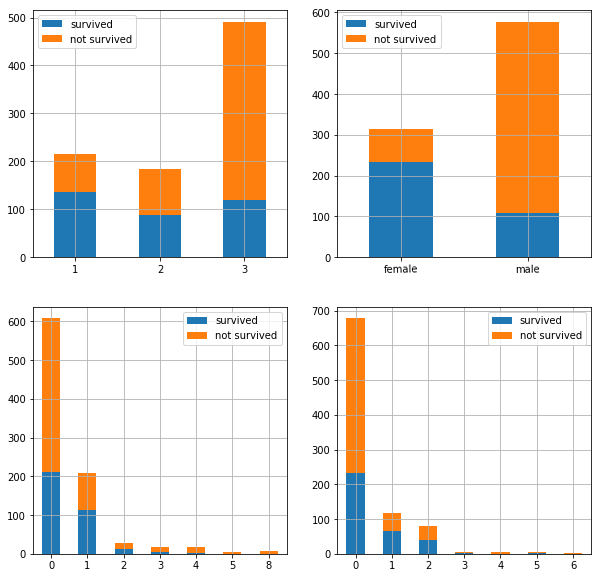

In [9]:
#画出条形图
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i,feature in {(0,0): 'Pclass', (0,1): 'Sex', (1,0): 'SibSp', (1,1): 'Parch'}.items():
    survived = train_df[feature][train_df["Survived"] == 1].value_counts()
    not_survived = train_df[feature][train_df["Survived"] == 0].value_counts()
    df = pd.DataFrame({"survived": survived, "not survived":not_survived})
    df.plot(kind="bar", stacked=True, ax=axes[i], grid=True, rot=1, title=feature)

<p> Pclass的头等舱有6成能获救，次等级舱4成，而一般乘客不到3成，土豪的获救率超过一般平民。   
   女性则超过7成能获救，男性不到2成，绅士们将Lady First的原则贯彻的很彻底，那怕在这种生死攸关的时刻。   
   单身人事占比远远超过结伴出行的人。

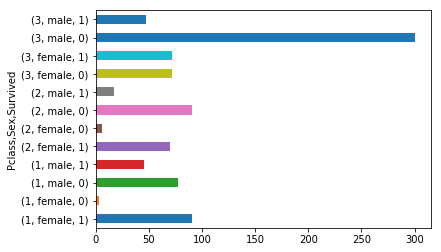

In [10]:
#看一看Pclass中Sex的获救情况
train_df.groupby(["Pclass", "Sex"])["Survived"].value_counts().plot(kind="barh")

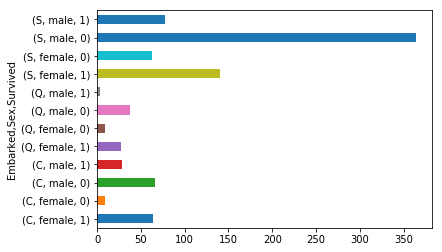

In [11]:
#看一看Embarked中Sex的获救情况
train_df.groupby(["Embarked", "Sex"])["Survived"].value_counts().plot(kind="barh")

In [12]:
#查看Pclass中Sex的存活率
train_df.groupby(["Pclass", "Sex"])["Survived"].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

In [13]:
#查看Embarked中Sex的存活率
train_df.groupby(["Embarked", "Sex"])["Survived"].mean()

Embarked  Sex   
C         female    0.876712
          male      0.305263
Q         female    0.750000
          male      0.073171
S         female    0.689655
          male      0.174603
Name: Survived, dtype: float64

<p> 从图中与数字比例可以看出头等舱中的女性以及C港口的女性获救率分别高达96%与87%
<p> 头等舱中以及C港口中的男性获救率分别为36%与30%
<p> 可以考虑将舱位与性别以及港口与性别分别作组合特称

(0, 85)

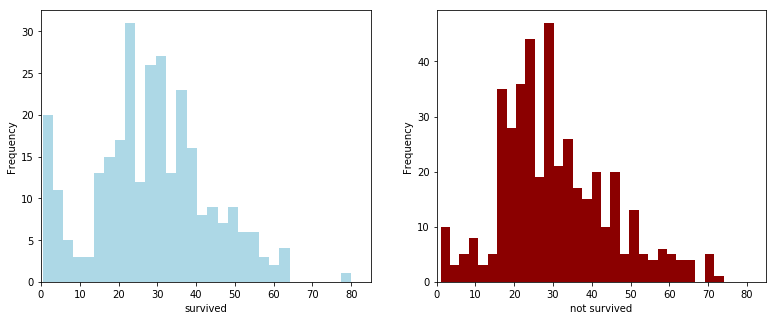

In [12]:
#现在我们来看看Age特征
fig= plt.figure(figsize=(13,5))
plt.subplot(121)
train_df["Age"][train_df["Survived"] == 1].plot(kind="hist", bins=30, color="lightblue")
plt.xlabel("survived")
plt.xlim([0,85])

plt.subplot(122)
train_df["Age"][train_df["Survived"] == 0].plot(kind="hist", bins=30, color="darkred")
plt.xlabel("not survived")
plt.xlim([0,85])

<p> 可以看出10岁以下（可能8岁）具有较高的存活率，80岁以上都有存活。
<p> 虽然生死攸关，但绅士们还是坚持女士与小孩优先原则。

### ●对数据进行特征清理

In [2]:
train_df.columns

NameError: name 'train_df' is not defined

In [14]:
#先删除不需要的数据
for data in combine:
    data.drop(["Ticket", "Cabin"], 1, inplace=True)

In [15]:
#将Sex特征转换为分类型
for data in combine:
    data["Sex"] = data["Sex"].map({"female":1, "male":0}).astype(int)

In [16]:
#用众数将Embarked特征补充完整并转换为分类型
train_df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)

for data in combine:
    data["Embarked"] = data["Embarked"].map({"C":2, "Q":1, "S":0}).astype(int)

In [17]:
#将Name特征中的Title提取出来
for data in combine:
    data["Title"] = data.Name.str.extract(" ([A-Za-z]+)\.", expand=False)

In [18]:
#看一看各个title出现的频次
pd.crosstab(test_df["Title"],test_df["Sex"])

Sex,0,1
Title,,
Col,2,0
Dona,0,1
Dr,1,0
Master,21,0
Miss,0,78
Mr,240,0
Mrs,0,72
Ms,0,1
Rev,2,0


In [19]:
#将意义相同的title归为一类，将出现次数较少以及不知道含义的title归类为Rare
for data in combine:
    data["Title"].replace(["Capt", "Col", "Don", "Dr", "Jonkheer", "Major", "Rev", "Sir"], "Rare", inplace=True)
    data["Title"].replace(["Countess", "Mme","Ms", "Dona"], "Mrs", inplace=True)
    data["Title"].replace(["Lady", "Mlle"], "Miss", inplace=True)

In [20]:
train_df[["Title", "Survived"]].groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.796875
Rare      0.285714
Name: Survived, dtype: float64

In [21]:
#将title转换为分类型
title_mapping = {"Mrs":1, "Miss":2, "Master":3, "Mr":4, "Rare":5}

for data in combine:
    data["Title"] = data["Title"].map(title_mapping)
    data["Title"] = data["Title"].fillna(0)

In [22]:
#将Name特征删除
for data in combine:
    data.drop(["Name"], 1, inplace=True)

In [23]:
#将Age补充完整，用平均值代替
for data in combine:
    mean_Age = data["Age"].mean()
    std_Age = data["Age"].std()
    null_Age_count = data["Age"].isnull().sum()
    fill_Age_list = np.random.randint(mean_Age-std_Age, mean_Age+std_Age, size=null_Age_count)
    data["Age"][np.isnan(data["Age"])] = fill_Age_list
    data["Age"] = data["Age"].astype(int)

C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [24]:
#将Age转换位分类型
train_df["AgeBand"] = pd.cut(train_df["Age"], bins=10)
train_df[["AgeBand", "Survived"]].groupby(train_df["AgeBand"]).mean()

,Survived
AgeBand,
"(-0.08, 8.0]",0.666667
"(8.0, 16.0]",0.384615
"(16.0, 24.0]",0.337662
"(24.0, 32.0]",0.365297
"(32.0, 40.0]",0.406977
"(40.0, 48.0]",0.325301
"(48.0, 56.0]",0.466667
"(56.0, 64.0]",0.375000
"(64.0, 72.0]",0.000000


In [25]:
#存活率接近的年龄段归为一类
for data in combine:
    data.loc[data["Age"] <= 8, "Age"] = 0
    data.loc[(data["Age"] > 8) & (data["Age"] <=48), "Age"] = 1
    data.loc[(data["Age"]) > 48 & (data["Age"] <=64), "Age"] = 2
    data.loc[(data["Age"] > 64) & (data["Age"] <=72), "Age"] = 3
    data.loc[data["Age"] > 72, "Age"] = 4

In [26]:
#将AgeBand删除
train_df.drop(["AgeBand"], 1, inplace=True)

In [27]:
#将Fare转换为分类型
test_df["Fare"].fillna(test_df["Fare"].dropna().median(), inplace=True)

train_df["FareBand"] = pd.qcut(train_df["Fare"], 5)
train_df[["FareBand", "Survived"]].groupby(["FareBand"]).mean()

,Survived
FareBand,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


In [28]:
for data in combine:
    data.loc[data["Fare"] <= 7.854, "Fare"] = 0
    data.loc[(data["Fare"] > 7.854) & (data["Fare"] <= 10.5), "Fare"] = 1
    data.loc[(data["Fare"] > 10.5) & (data["Fare"] <= 21.679), "Fare"] = 2
    data.loc[(data["Fare"] > 21.679) & (data["Fare"] <= 39.688), "Fare"] = 3
    data.loc[data["Fare"] > 39.688, "Fare"] = 4   

In [29]:
train_df.drop(["FareBand"], 1, inplace=True)

In [30]:
#创Familysize特征
for data in combine:
    data["Familysize"] = train_df["SibSp"] + train_df["Parch"] + 1

train_df[["Survived", "Familysize"]].groupby(["Familysize"]).mean()

,Survived
Familysize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


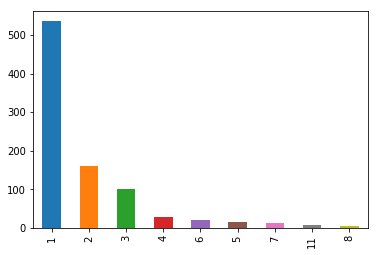

In [31]:
train_df["Familysize"].value_counts().plot(kind="bar", title="Familysize")

In [32]:
#按家庭人数将乘客分类为单身，小家庭，大家庭（人数大于4的家庭）
for data in combine:
    data.loc[data["Familysize"] == 1, "Familysize"] = 0
    data.loc[(data["Familysize"] > 1) & (data["Familysize"] <= 4), "Familysize"] = 1
    data.loc[data["Familysize"] > 4, "Familysize"] = 2

In [33]:
for data in combine:
    data.drop(["SibSp", "Parch"], 1, inplace=True)

In [34]:
#创建Sex*Pclass,Sex*Embarked和Age*Pclass特征
for data in combine:
    data["Sex*Pclass"] = data["Sex"] * data["Pclass"]
    data["Sex*Embarked"] = data["Sex"] * data["Embarked"]
    #data["Age*Pclass"] = data["Age"]*data["Pclass"]

In [35]:
for data in combine:
    data.drop(["Embarked"], 1, inplace=True)

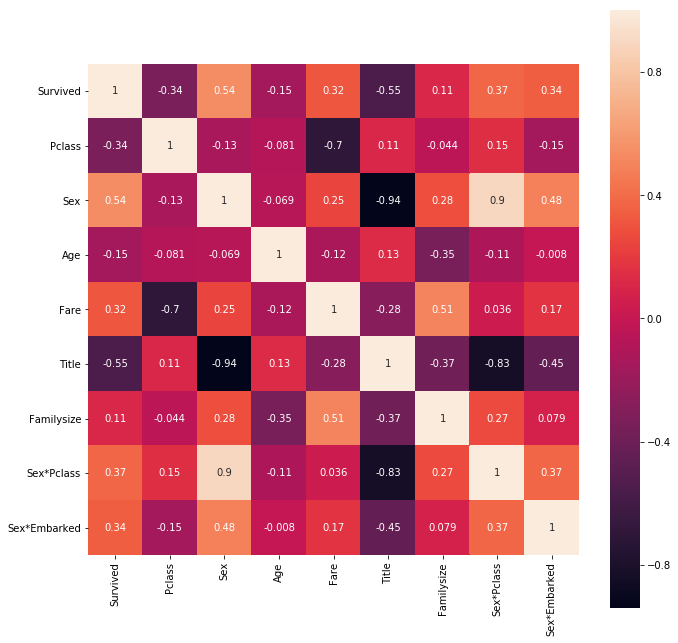

In [36]:
#看一看各个特征的热图
import seaborn as sns
fig = plt.figure(figsize=(11,11))
sns.heatmap(train_df.drop(["PassengerId"], 1).corr(), square=True, annot=True)

In [37]:
train_df.head(5), test_df.head(5)

(   PassengerId  Survived  Pclass  Sex  Age  Fare  Title  Familysize  \
 0            1         0       3    0    2   0.0      4           1   
 1            2         1       1    1    2   4.0      1           1   
 2            3         1       3    1    2   1.0      2           0   
 3            4         1       1    1    2   4.0      1           1   
 4            5         0       3    0    2   1.0      4           0   
 
    Sex*Pclass  Sex*Embarked  
 0           0             0  
 1           1             2  
 2           3             0  
 3           1             0  
 4           0             0  ,
    PassengerId  Pclass  Sex  Age  Fare  Title  Familysize  Sex*Pclass  \
 0          892       3    0    2   0.0      4           1           0   
 1          893       3    1    2   0.0      1           1           3   
 2          894       2    0    2   1.0      4           0           0   
 3          895       3    0    2   1.0      4           1           0   
 4       

### ●模型建立

In [38]:
#准备训练集与测试集
X_train = train_df.drop(["PassengerId", "Survived"], 1)
y_train = train_df["Survived"]
X_test = test_df.drop(["PassengerId"], 1)
X_train.shape, y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [39]:
#将加载的模型函数放入一个字典
clfs = {"Logreg":LogisticRegression(), "Perceptron":Perceptron(), "SGD":SGDClassifier(), "DT":DecisionTreeClassifier(),
       "GaussianNB":GaussianNB(), "RFC":RandomForestClassifier(), "SVC":SVC(), "Knn":KNeighborsClassifier()}

In [40]:
#用交叉验证来查看各个模型的情况
from sklearn import cross_validation
X_train_c, X_test_c, y_train_c, y_test_c = cross_validation.train_test_split(X_train, y_train, random_state=4)
cross_model = []
cross_score = []
for name,c in clfs.items():
    cross_model.append(name)
    clf = c
    clf.fit(X_train_c,y_train_c)
    score = clf.score(X_test_c, y_test_c)
    cross_score.append(score)

df_cross_scores = pd.DataFrame({"Model":cross_model, "Score":cross_score})
df_cross_scores.sort_values(by="Score", ascending=False)

C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\b_xia\AppData\Local\Continuum\anaconda3

,Model,Score
5,RFC,0.865471
6,SVC,0.860987
3,DT,0.856502
7,Knn,0.856502
0,Logreg,0.834081
4,GaussianNB,0.816143
1,Perceptron,0.811659
2,SGD,0.766816


In [41]:
cross_val_model = []
cross_val_score = []
for name,c in clfs.items():
    cross_val_model.append(name)
    clf = c
    score = cross_validation.cross_val_score(clf, X_train, y_train, cv=7, scoring="accuracy")
    cross_val_score.append(score.mean())

df_cross_val_scores = pd.DataFrame({"Model":cross_val_model, "Score":cross_val_score})
df_cross_val_scores.sort_values(by="Score", ascending=False)

C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users

,Model,Score
3,DT,0.840645
5,RFC,0.829484
7,Knn,0.826093
6,SVC,0.824941
0,Logreg,0.815871
4,GaussianNB,0.793462
2,SGD,0.730962
1,Perceptron,0.614021


In [42]:
#看一看各个模型的情况
model = []
scores = []
fited_clf = {}
for name,c in clfs.items():
    clf = c
    clf.fit(X_train, y_train)
    score = clf.score(X_train, y_train)
    model.append(name)
    scores.append(score)
    fited_clf[name] = clf
    
df_scores = pd.DataFrame({"Model":model, "score":scores})
df_scores.sort_values(by="score", ascending=False)

C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\b_xia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarni

,Model,score
3,DT,0.861953
5,RFC,0.860831
7,Knn,0.843996
0,Logreg,0.829405
6,SVC,0.829405
4,GaussianNB,0.793490
1,Perceptron,0.783389
2,SGD,0.768799


In [43]:
#prediction = fited_clf["DT"].predict(X_test)
#prediction

In [44]:
#submission = pd.DataFrame({"PassengerId":test_df["PassengerId"], "Survived":prediction})
#submission

In [45]:
#submission.to_csv("my Titanic-0.csv", index=False)

from sklearn.learning_curve import learning_curve
lv_clf = fited_clf["DT"]
test_sizes, train_loss, test_loss = learning_curve(lv_clf, X_train, y_train, cv=10, 
                                                   train_sizes=np.linspace(0.05, 1.00, 20))
train_loss_mean = np.mean(train_loss, axis=1)
test_loss_mean = np.mean(test_loss, axis=1)
plt.plot(test_sizes, train_loss_mean, "o-", c="r")
plt.plot(test_sizes, test_loss_mean, "o-", c="g")

from sklearn.learning_curve import learning_curve
for name,c in fited_clf.items():
    test_sizes, train_score, test_score = learning_curve(c, X_train, y_train, cv=10, train_sizes=np.linspace(0.05, 1.0, 20))
    train_score_mean = np.mean(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    fig = plt.figure()
    plt.plot(test_sizes, train_score_mean, "o-", c="r")
    plt.plot(test_sizes, test_score_mean, "o-", c="g")
    plt.grid()
    plt.xlabel(name)
    plt.ylabel("Score")

In [56]:
from sklearn.ensemble import BaggingClassifier

clf_en = clf
bagging_clf = BaggingClassifier(clf_en, n_estimators=100, max_samples=0.7, max_features=1.0, bootstrap=True, bootstrap_features=False)


In [57]:
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_train, y_train)

0.8597081930415263

In [51]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.8619528619528619